# Which board game should you play?

## 📖 Background

After a tiring week, what better way to unwind than a board game night with friends and family? But the question remains: which game should you pick? You have gathered a dataset containing information of over `20,000` board games. It's time to utilize your analytical skills and use data-driven insights to persuade your group to try the game you've chosen!

## 💾 The Data

You've come across a dataset titled `bgg_data.csv` containing details on over `20,000` ranked board games from the BoardGameGeek (BGG) website. BGG is the premier online hub for board game enthusiasts, hosting data on more than `100,000` games, inclusive of both ranked and unranked varieties. This platform thrives due to its active community, who contribute by posting reviews, ratings, images, videos, session reports, and participating in live discussions.

This specific dataset, assembled in `February 2021`, encompasses all ranked games listed on BGG up to that date. Games without a ranking were left out because they didn't garner enough reviews; for a game to earn a rank, it needs a minimum of `30` votes.

In this dataset, each row denotes a board game and is associated with some information.

| Column     | Description              |
|------------|--------------------------|
| `ID` | The ID of the board game. |
| `Name` | The name of the board game.|
| `Year Published` | The year when the game was published.|
| `Min Players` | The minimum number of player recommended for the game.|
| `Max Players` | The maximum number of player recommended for the game.|
| `Play Time` | The average play time suggested by game creators, measured in minutes.|
| `Min Age` | The recommended minimum age of players.|
| `Users Rated` | The number of users who rated the game.|
| `Rating Average` | The average rating of the game, on a scale of 1 to 10.|
| `BGG Rank` | The rank of the game on the BoardGameGeek (BGG) website.| 
| `Complexity Average` | The average complexity value of the game, on a scale of 1 to 5.|
| `Owned Users` |  The number of BGG registered owners of the game.| 
| `Mechanics` | The mechanics used by the game.| 
| `Domains` | The board game domains that the game belongs to.|

**Source:** Dilini Samarasinghe, July 5, 2021, "BoardGameGeek Dataset on Board Games", IEEE Dataport, doi: https://dx.doi.org/10.21227/9g61-bs59.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
boardgame = pd.read_csv('data/bgg_data.csv')
boardgame

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,8.79,1,3.86,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,8.61,2,2.84,65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,8.66,3,3.91,28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,8.43,4,3.24,87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,8.70,5,4.22,16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20338,16398.0,War,0.0,2,2,30,4,1340,2.28,20340,0.01,427.0,NaN,Children's Games
20339,7316.0,Bingo,1530.0,2,99,60,5,2154,2.85,20341,1.05,1533.0,"Betting and Bluffing, Bingo, Pattern Recognition",Party Games
20340,5048.0,Candy Land,1949.0,2,4,30,3,4006,3.18,20342,1.08,5788.0,Roll / Spin and Move,Children's Games
20341,5432.0,Chutes and Ladders,-200.0,2,6,30,3,3783,2.86,20343,1.02,4400.0,"Dice Rolling, Grid Movement, Race, Roll / Spin...",Children's Games


# Data Cleaning Procces

## Meaning of variables and their type

In [4]:
def boardgame_info():
    temp = pd.DataFrame(index=boardgame.columns)
    temp["Datatype"] = boardgame.dtypes
    temp["Not null values"] = boardgame.count()
    temp["Null Values"] = boardgame.isnull().sum()
    temp["Percentage of Null Values"] = (boardgame.isnull().mean())*100
    temp["Unique count"] = boardgame.nunique()
    return temp
boardgame_info()

,Datatype,Not null values,Null Values,Percentage of Null Values,Unique count
ID,float64,20327,16,0.078651,20327
Name,object,20343,0,0.000000,19976
Year Published,float64,20342,1,0.004916,188
Min Players,int64,20343,0,0.000000,11
Max Players,int64,20343,0,0.000000,54
Play Time,int64,20343,0,0.000000,116
Min Age,int64,20343,0,0.000000,21
Users Rated,int64,20343,0,0.000000,2973
Rating Average,float64,20343,0,0.000000,627
BGG Rank,int64,20343,0,0.000000,20343


### Solving the id problem

In [5]:
# Creating a sequence of numbers to substitute the id
sequence_of_numbers = list(range(1, len(boardgame) + 1))
boardgame['ID'] = sequence_of_numbers

### Finding the null Year

In [6]:
# Find the rows with null values in the `Year Published` column
null_values_mask = boardgame['Year Published'].isnull()
null_values_rows = boardgame[null_values_mask]

# Print the rows with null values in the `Year Published` column
null_values_rows

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
13984,13985,Hus,NaN,2,2,40,0,38,6.28,13986,0.02,NaN,NaN,NaN


In [7]:
boardgame.loc[boardgame['ID'] == 13985, 'Year Published'] = 1855

In [8]:
#cleaned data

def boardgame_info():
    temp = pd.DataFrame(index=boardgame.columns)
    temp["Datatype"] = boardgame.dtypes
    temp["Not null values"] = boardgame.count()
    temp["Null Values"] = boardgame.isnull().sum()
    temp["Percentage of Null Values"] = (boardgame.isnull().mean())*100
    temp["Unique count"] = boardgame.nunique()
    return temp
boardgame_info()

,Datatype,Not null values,Null Values,Percentage of Null Values,Unique count
ID,int64,20343,0,0.000000,20343
Name,object,20343,0,0.000000,19976
Year Published,float64,20343,0,0.000000,188
Min Players,int64,20343,0,0.000000,11
Max Players,int64,20343,0,0.000000,54
Play Time,int64,20343,0,0.000000,116
Min Age,int64,20343,0,0.000000,21
Users Rated,int64,20343,0,0.000000,2973
Rating Average,float64,20343,0,0.000000,627
BGG Rank,int64,20343,0,0.000000,20343


### Creating new columns for better analysis

**Solely** relying on Rating Average is **insufficient** for our analysis, as a game could have a Rating Average of 9 with only 10 Users Rated. This average is not entirely representative of the game's overall quality. To address this limitation, I introduced the Weighted Rating column, which **prioritizes games with high ratings from a larger number of users**.

Another challenge we encountered was the **varying number of players supported by each game**. One approach was to create a categorical column by concatenating the minimum and maximum number of players. However, this would result in a large number of categories, given the unique combinations of min and max player counts. For instance, the dataset includes games with min players of 1 and max players of 3, 2 and 3, and 1 and 4, leading to an unwieldy number of options for similar values. Therefore, we opted for a more sensible approach: creating a column with the "expected" number of players. For a game with a minimum of 2 players and a maximum of 4 players, the "expected" number of players is 3. While it's more likely that a game with 4 players will be more enjoyable, using the expected number of players **allows us to effectively aggregate games based on their player count**.

In [9]:
# Create a new column 'Num Players' by finding the middle value between Min and Max Players
boardgame['Num Players'] = boardgame[['Min Players', 'Max Players']].mean(axis=1)

# Create a new column 'Weighted Rating' to calculate the weighted average rating
boardgame['Weighted Rating'] = boardgame['Users Rated'] * boardgame['Rating Average']

boardgame.head(10)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains,Num Players,Weighted Rating
0,1,Gloomhaven,2017.0,1,4,120,14,42055,8.79,1,3.86,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games",2.5,369663.45
1,2,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,8.61,2,2.84,65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games",3.0,358546.23
2,3,Brass: Birmingham,2018.0,2,4,120,14,19217,8.66,3,3.91,28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games,3.0,166419.22
3,4,Terraforming Mars,2016.0,1,5,120,12,64864,8.43,4,3.24,87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games,3.0,546803.52
4,5,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,8.70,5,4.22,16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games",4.5,117171.60
5,6,Gloomhaven: Jaws of the Lion,2020.0,1,4,120,14,8392,8.87,6,3.55,21609.0,"Action Queue, Campaign / Battle Card Driven, C...","Strategy Games, Thematic Games",2.5,74437.04
6,7,Through the Ages: A New Story of Civilization,2015.0,2,4,120,14,23061,8.43,7,4.41,26985.0,"Action Points, Auction/Bidding, Auction: Dutch...",Strategy Games,3.0,194404.23
7,8,Gaia Project,2017.0,1,4,150,12,16352,8.49,8,4.35,20312.0,"End Game Bonuses, Hexagon Grid, Income, Modula...",Strategy Games,2.5,138828.48
8,9,Star Wars: Rebellion,2016.0,2,4,240,14,23081,8.42,9,3.71,34849.0,"Area Majority / Influence, Area Movement, Area...",Thematic Games,3.0,194342.02
9,10,Twilight Struggle,2005.0,2,2,180,13,40814,8.29,10,3.59,56219.0,"Action/Event, Advantage Token, Area Majority /...","Strategy Games, Wargames",2.0,338348.06


An idea struck me: what if we categorized games into solo, two-player, and multiplayer options? This would allow us to **better visualize** whether multiplayer games are more popular than solo or two-player games.

In [10]:
# Create a new column named 'player_count_category'
def categorize_player_count(min_players, max_players):
    if min_players == 1 and max_players == 1:
        return "Solo"
    elif min_players == 2 and max_players == 2:
        return "Two-Player"
    else:
        return "Multi-Player"

boardgame['player_count_category'] = boardgame.apply(lambda row: categorize_player_count(row['Min Players'], row['Max Players']), axis=1)

# Rename the column 'player_count_category' to 'Players Category'
boardgame.rename(columns={'player_count_category': 'Players Category'}, inplace=True)

# Print the DataFrame
boardgame.head(10)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains,Num Players,Weighted Rating,Players Category
0,1,Gloomhaven,2017.0,1,4,120,14,42055,8.79,1,3.86,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games",2.5,369663.45,Multi-Player
1,2,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,8.61,2,2.84,65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games",3.0,358546.23,Multi-Player
2,3,Brass: Birmingham,2018.0,2,4,120,14,19217,8.66,3,3.91,28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games,3.0,166419.22,Multi-Player
3,4,Terraforming Mars,2016.0,1,5,120,12,64864,8.43,4,3.24,87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games,3.0,546803.52,Multi-Player
4,5,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,8.70,5,4.22,16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games",4.5,117171.60,Multi-Player
5,6,Gloomhaven: Jaws of the Lion,2020.0,1,4,120,14,8392,8.87,6,3.55,21609.0,"Action Queue, Campaign / Battle Card Driven, C...","Strategy Games, Thematic Games",2.5,74437.04,Multi-Player
6,7,Through the Ages: A New Story of Civilization,2015.0,2,4,120,14,23061,8.43,7,4.41,26985.0,"Action Points, Auction/Bidding, Auction: Dutch...",Strategy Games,3.0,194404.23,Multi-Player
7,8,Gaia Project,2017.0,1,4,150,12,16352,8.49,8,4.35,20312.0,"End Game Bonuses, Hexagon Grid, Income, Modula...",Strategy Games,2.5,138828.48,Multi-Player
8,9,Star Wars: Rebellion,2016.0,2,4,240,14,23081,8.42,9,3.71,34849.0,"Area Majority / Influence, Area Movement, Area...",Thematic Games,3.0,194342.02,Multi-Player
9,10,Twilight Struggle,2005.0,2,2,180,13,40814,8.29,10,3.59,56219.0,"Action/Event, Advantage Token, Area Majority /...","Strategy Games, Wargames",2.0,338348.06,Two-Player


Another challenge we face is classifying games that span multiple domains. One option is to categorize into primary or secondary.

In [11]:
# Select the first value from the original column and store it in a new column named 'first_value'
boardgame['Primary Domain'] = boardgame['Domains'].str.split(',').str[0]

# Split the original column by commas and select the second value, storing it in a new column named 'second_value'
boardgame['Secondary Domain'] = boardgame['Domains'].str.split(',').str[1]

# Analysis

## To what extent does the number of players affect the average rating of a board game?

At first glance, multiplayer games appear to be more popular, and this assumption is supported below.

In [12]:
# Sort the DataFrame by the 'Players Category' column
boardgame = boardgame.sort_values(by='Players Category')

# Calculate the weighted average for each player category
average_weighted_ratings = boardgame.groupby('Players Category')['Weighted Rating'].mean()

# Print the average weighted ratings
print(average_weighted_ratings)

Players Category
Multi-Player    6519.053988
Solo            2083.888782
Two-Player      3525.325197
Name: Weighted Rating, dtype: float64


Without filtering the data, we might be overwhelmed by the sheer number of games listed in the dataframe, making it **difficult to extract meaningful insights**.

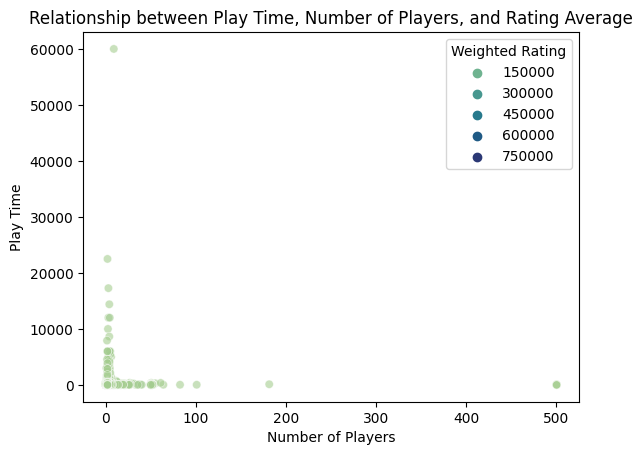

In [13]:
# Create a scatter plot with num_players and play_time on the y-axis and rating_average on the x-axis
sns.scatterplot(x='Num Players', y='Play Time', hue='Weighted Rating', data=boardgame, palette='crest', alpha=0.6)


plt.title('Relationship between Play Time, Number of Players, and Rating Average')
plt.xlabel('Number of Players')
plt.ylabel('Play Time')
plt.show()

To gain more **meaningful insights**, I decided to **filter** the data based on criteria relevant to my **group of friends' preferences**:

**Duration**: I opted for games with a playtime under **3 hours**.

**Number of Players**: Considering the size of our group, I filtered the games to include only those with a **maximum of 10 players**.

**User Ratings**: To ensure an enjoyable gaming experience, I focused on games with a Weighted Rating **exceeding 300,000, indicating favorable user reviews.**

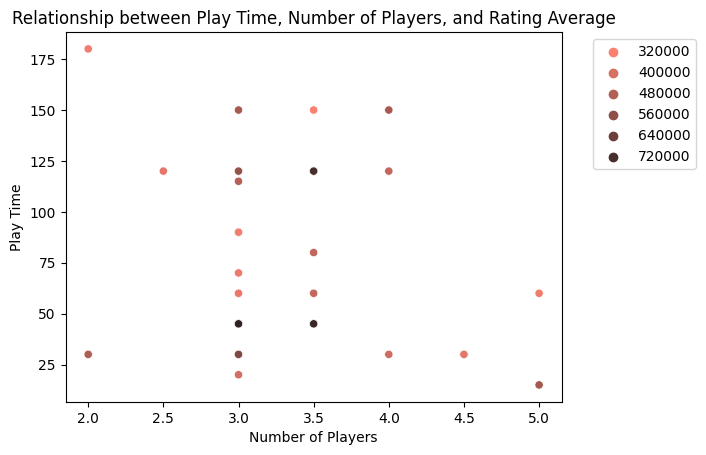

In [14]:
# Filter the data for better visualization
filtered_boardgame = boardgame[(boardgame['Weighted Rating'] > 300000) & (boardgame['Num Players'] > 0) & (boardgame['Num Players'] <= 10) & (boardgame['Play Time'] <= 180) & (boardgame['Play Time'] > 0)]


# Create a scatter plot with num_players and play_time on the y-axis and rating_average on the x-axis
sns.scatterplot(x='Num Players', y='Play Time', hue='Weighted Rating', data=filtered_boardgame, palette="dark:salmon_r", alpha=1)


plt.title('Relationship between Play Time, Number of Players, and Rating Average')
plt.xlabel('Number of Players')
plt.ylabel('Play Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The graph above reveals that the most popular games have a player count of 3 to 4 and a playtime between 1 to 2 hours. This combination is ideal for a casual game night with friends or family. For more experienced or hardcore board gamers, there are always other options available.

The table below showcases some of the top-rated board games that fit the criteria of a casual game night. These games include classics like Catan, Carcassonne, 7 Wonders, and Ticket to Ride, as well as some newer favorites like Pandemic, Terraforming Mars, and Splendor.

In [16]:
filtered_boardgame.sort_values(by='Weighted Rating', ascending=False)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains,Num Players,Weighted Rating,Players Category,Primary Domain,Secondary Domain
98,99,Pandemic,2008.0,2,4,45,8,102214,7.61,99,2.41,155312.0,"Action Points, Cooperative Game, Hand Manageme...","Family Games, Strategy Games",3.0,777848.54,Multi-Player,Family Games,Strategy Games
177,178,Carcassonne,2000.0,2,5,45,7,101853,7.42,178,1.91,149337.0,"Area Majority / Influence, Map Addition, Tile ...",Family Games,3.5,755749.26,Multi-Player,Family Games,NaN
394,395,Catan,1995.0,3,4,120,10,101510,7.15,395,2.32,154531.0,"Dice Rolling, Hexagon Grid, Income, Modular Bo...","Family Games, Strategy Games",3.5,725796.50,Multi-Player,Family Games,Strategy Games
60,61,7 Wonders,2010.0,2,7,30,10,84371,7.75,61,2.33,112410.0,"Card Drafting, Drafting, Hand Management, Set ...","Family Games, Strategy Games",4.5,653875.25,Multi-Player,Family Games,Strategy Games
97,98,Dominion,2008.0,2,4,30,13,78089,7.62,98,2.36,101839.0,"Deck Bag and Pool Building, Delayed Purchase, ...",Strategy Games,3.0,595038.18,Multi-Player,Strategy Games,NaN
3,4,Terraforming Mars,2016.0,1,5,120,12,64864,8.43,4,3.24,87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games,3.0,546803.52,Multi-Player,Strategy Games,NaN
173,174,Ticket to Ride,2004.0,2,5,60,8,71611,7.42,174,1.85,97463.0,"Card Drafting, End Game Bonuses, Hand Manageme...",Family Games,3.5,531353.62,Multi-Player,Family Games,NaN
92,93,Codenames,2015.0,2,8,15,14,67688,7.62,93,1.29,107682.0,"Communication Limits, Memory, Push Your Luck, ...",Party Games,5.0,515782.56,Multi-Player,Party Games,NaN
27,28,Puerto Rico,2002.0,3,5,150,12,63128,7.99,28,3.28,73413.0,"Action Drafting, End Game Bonuses, Follow, Hid...",Strategy Games,4.0,504392.72,Multi-Player,Strategy Games,NaN
30,31,Agricola,2007.0,1,5,150,12,63498,7.94,31,3.64,75679.0,"Advantage Token, Automatic Resource Growth, Ca...",Strategy Games,3.0,504174.12,Multi-Player,Strategy Games,NaN


As a bonus recommendation, check out **Codenames**. This versatile game can accommodate a large number of players, making it ideal for game nights with **"crowds"**." Divided into two teams, players work together to identify their own agents based on clues provided by their respective spymasters. **IT IS AWESOME**.